<a href="https://colab.research.google.com/github/MMRES-PyBootcamp/MMRES-python-bootcamp2022/blob/main/15_overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

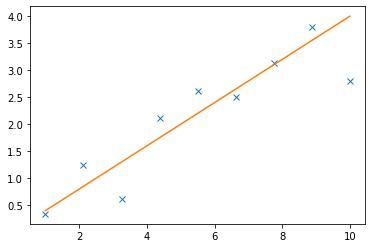

In [1]:
import numpy as np
from matplotlib import pyplot as plt

x = np.linspace(1,10,9)
m = 0.4
y0 = m * x
y = y0 + np.random.normal(0,0.5,len(x))

plt.plot(x,y,"x")
plt.plot(x,y0,"-")

In [2]:
coef = np.polyfit(x,y,10)
fit = np.poly1d(coef)

coef0 = np.polyfit(x,y,1)
fit0 = np.poly1d(coef0)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


(0.0, 6.0)

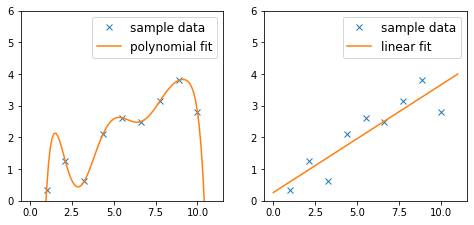

In [4]:
finex = np.linspace(0,11,100)
fig, axs = plt.subplots(ncols=2,figsize=(8,3.5))
ax = axs[0]
ax.plot(x,y,"x", label="sample data")
#ax.plot(finex,m*finex,"-", label="true distribution")
ax.plot(finex,fit(finex),"-", label="polynomial fit")
#ax.plot(finex,fit0(finex),"-", label="linear fit")

ax.legend(fontsize=12)
ax.set_ylim(0,6)

ax = axs[1]
ax.plot(x,y,"x", label="sample data")
#ax.plot(finex,m*finex,"-", label="true distribution")
#ax.plot(finex,fit(finex),"-", label="polynomial fit")
ax.plot(finex,fit0(finex),"-", label="linear fit")

ax.legend(fontsize=12)
ax.set_ylim(0,6)

#plt.savefig("data/overfitting.png")

In [5]:
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor

from matplotlib import pyplot as plt

We are looking at the same MNIST dataset of handwritten digits and want to make some adjustments to our neural network architecture to improve our performance. First, we load the dataset again.

In [7]:
device = "cuda" #make sure colab runtime has GPU acceleration activated

In [8]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [9]:
from torch.utils.data import DataLoader

batch_size = 512

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

We keep the fully connected layers, but first add a convolutional block. This block acts as a so-called feature extractor, finding shapes and patterns in the data. These features are then classified with the fully-connected block.  
Check the documentation for the convolutional layer: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
Documentation for the maxpooling layer: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

In [11]:
in_dim = 28*28
out_dim = 10

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.neural_network = nn.Sequential(
            nn.Linear(in_dim, 512),  # input dimension, hidden1 dimension
            nn.Dropout(p=0.5, inplace=False),
            nn.ReLU(),               # Non-linear activation function
            nn.Linear(512, 512),     # hidden1 dimension, hidden2 dimension
            nn.Dropout(p=0.5, inplace=False),
            nn.ReLU(),               # Non-linear activation function
            nn.Linear(512, out_dim), # hidden2 dimension, output dimension
            nn.Dropout(p=0.5, inplace=False),
        )

    def forward(self, x):
        x = self.flatten(x)          # input data preparation
        output = self.neural_network(x)
        return output

In [12]:
model = NeuralNetwork().to(device) #uncomment for GPU execution
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (neural_network): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=10, bias=True)
    (7): Dropout(p=0.5, inplace=False)
  )
)


In [13]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 2 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    # compute accuracy
    train_acc = correct/size * 100
    return loss, train_acc

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    test_acc = 100*correct
    print(f"Test Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return test_loss, test_acc



In [14]:
loss_fn = nn.CrossEntropyLoss() # nn.MSELoss() # mean squared error (MSE) loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # stochastic gradient descent (SGD) optimizer

In [15]:
epochs = 20
train_losss, train_accs = [], []
test_losss, test_accs = [], []
for t in range(epochs):
    print(f"Epoch {t+1}")
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(test_dataloader, model, loss_fn)
    train_losss.append(train_loss)
    train_accs.append(train_acc)
    test_losss.append(test_loss)
    test_accs.append(test_acc)
print("Done!")

Epoch 1
Test Error: Accuracy: 93.6%, Avg loss: 0.262022
Epoch 2
Test Error: Accuracy: 95.4%, Avg loss: 0.180205
Epoch 3
Test Error: Accuracy: 96.1%, Avg loss: 0.143855
Epoch 4
Test Error: Accuracy: 96.9%, Avg loss: 0.117847
Epoch 5
Test Error: Accuracy: 97.2%, Avg loss: 0.109688
Epoch 6
Test Error: Accuracy: 97.3%, Avg loss: 0.101857
Epoch 7
Test Error: Accuracy: 97.5%, Avg loss: 0.086490
Epoch 8
Test Error: Accuracy: 97.4%, Avg loss: 0.091174
Epoch 9
Test Error: Accuracy: 97.8%, Avg loss: 0.079890
Epoch 10
Test Error: Accuracy: 97.8%, Avg loss: 0.076819
Epoch 11
Test Error: Accuracy: 97.9%, Avg loss: 0.071156
Epoch 12
Test Error: Accuracy: 98.0%, Avg loss: 0.070073
Epoch 13
Test Error: Accuracy: 97.9%, Avg loss: 0.070979
Epoch 14
Test Error: Accuracy: 98.0%, Avg loss: 0.068555
Epoch 15
Test Error: Accuracy: 98.0%, Avg loss: 0.065410
Epoch 16
Test Error: Accuracy: 98.2%, Avg loss: 0.064230
Epoch 17
Test Error: Accuracy: 98.0%, Avg loss: 0.067657
Epoch 18
Test Error: Accuracy: 98.3%, Av

In [16]:
train_losss = torch.tensor(train_losss).cpu()
train_accs = torch.tensor(train_accs).cpu()
test_losss = torch.tensor(test_losss).cpu()
test_accs = torch.tensor(test_accs).cpu()

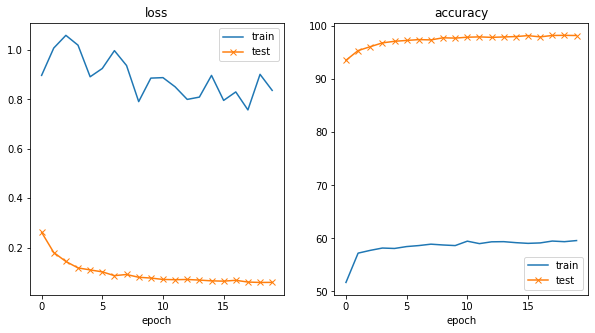

In [17]:
fig, axs = plt.subplots(figsize=(10,5), ncols=2)

ax = axs[0]
ax.plot(train_losss.cpu(), label="train")
ax.plot(test_losss.cpu(), "x-", label="test")

ax.set_title("loss")
ax.set_xlabel("epoch")
ax.legend()

ax = axs[1]
ax.plot(train_accs.cpu(), label="train")
ax.plot(test_accs.cpu(), "x-", label="test")

ax.set_title("accuracy")
ax.set_xlabel("epoch")
ax.legend()